# Word2Vec and tSNE

DS 5001 Text as Data

**Purpose:** We create word embeddings with novel data using word2vec and visualize results with tSNE.

# Set Up

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
# Adjust this for a new corpus
data_prefix = 'winereviews'
table_dir =  f'{data_home}/{data_prefix}'
OHCO = ['doc_id', 'sent_id', 'token_id']
# PARA = OHCO[:4] # Paragraphs
# SENT = OHCO[:5] # Sentences
BAG = OHCO[:1]
# BAG = SENT

In [3]:
# word2vec parameters
w2v_params = dict(
    window = 2,
    vector_size = 200,
    min_count = 50, # THIS LIMITS OUR VOCAB
    workers = 4
)

In [4]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE as tsne
import plotly_express as px

In [5]:
import gensim
gensim.__version__

'4.3.3'

# Import `TOKENS` and `VOCAB`

We import data from the TOKEN table of the novels corpus, excluding proper nouns.

In [9]:
TOKENS = pd.read_csv(f'{table_dir}/{data_prefix}-TOKENS.csv').set_index(OHCO)

In [10]:
TOKENS.head()

token term_str  term_id
doc_id sent_id token_id                           
336    0       0          Gritty   gritty     7200
               1         heavily  heavily     7493
               2         roasted  roasted    13107
               3          aromas   aromas     1107
               5         peanuts  peanuts    11308

In [12]:
VOCAB = pd.read_csv(f'{table_dir}/{data_prefix}-VOCAB.csv').set_index('term_str')

In [13]:
VOCAB = VOCAB[~VOCAB.index.isna()] # There is NaN in the index for some reason

In [14]:
VOCAB.sample(5)

,n,f,stem,sw,go
term_str,,,,,
augmented,3,0.000004,augment,False,True
silk,22,0.000029,silk,False,True
leathery,147,0.000191,leatheri,False,True
unappealing,3,0.000004,unapp,False,True
apparent,46,0.000060,appar,False,True


# Convert to Gensim

We now create a Gensim-style corpus of docs, a list of lists of tokens.

In [18]:
docs = TOKENS.dropna(subset=['term_str'])\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1] # Lose single word docs

In [19]:
print(docs[:2])

[['gritty', 'heavily', 'roasted', 'aromas', 'peanuts', 'herbal', 'berry', 'fruits', 'lead', 'scratchy', 'tannic', 'palate', 'tastes', 'burnt', 'oak', 'raw', 'plum', 'currant', 'finish', 'tastes', 'briny', 'harsh', 'version', 'wine', 'much', 'better', 'rough', 'front', 'back'], ['easy', 'inviting', 'selection', 'mentholated', 'streak', 'soft', 'red', 'currant', 'cherry', 'core', 'wine', 'light', 'breezy', 'palate', 'offers', 'thin', 'quickly', 'flavors', 'fleeting', 'finish']]


In [20]:
vocab = Dictionary(docs)

# Generate word embeddings with Gensim's module

In [21]:
model = word2vec.Word2Vec(docs, **w2v_params)

In [27]:
model.wv.vectors

array([[ 0.03175171,  0.39888853, -0.24694976, ..., -0.28689712,
        -0.456163  , -0.07471877],
       [-0.6436024 , -0.2560293 , -0.21976295, ...,  0.37934375,
        -0.03910411,  0.3111382 ],
       [ 0.18895206, -0.54355717, -0.35480195, ..., -0.0567149 ,
         0.22823417, -0.08716431],
       ...,
       [ 0.03647754, -0.1593164 , -0.19911398, ...,  0.03827444,
        -0.03641688, -0.11754956],
       [-0.11234641, -0.13698374, -0.03081412, ..., -0.07749009,
        -0.17908004,  0.10491291],
       [ 0.13420333, -0.03049069, -0.05348169, ..., -0.22392364,
        -0.06451975, -0.1791094 ]], dtype=float32)

# Visualize with tSNE

## Convert model to data frame

In [28]:
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        vec = None
    return vec

In [29]:
WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)

In [30]:
WV

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
term_str,,,,,,,,,,,,,,,,,,,,,
absolutely,0.074518,0.095259,0.330390,0.149206,-0.061412,-0.214790,-0.020153,0.177876,-0.106229,0.001756,...,0.068093,0.030263,-0.094137,-0.041076,0.191263,0.054498,0.263944,-0.208697,0.008714,-0.103119
accent,-0.087529,-0.180289,-0.236806,0.150572,0.238174,0.046616,0.008719,0.014515,-0.063068,0.235604,...,0.340845,-0.060659,0.135911,0.026235,0.159637,0.165261,-0.229997,0.071990,0.003996,-0.007894
accented,-0.025323,-0.339561,-0.141064,0.122984,0.272230,0.134846,-0.057597,0.163097,0.037234,0.298469,...,0.397625,-0.151897,0.311109,-0.019400,0.223651,0.263241,-0.401889,0.152827,-0.039742,-0.034901
accents,-0.083797,-0.125810,-0.259831,0.031189,0.221308,0.037936,-0.039388,0.115296,-0.079490,0.158839,...,0.270272,-0.070560,0.236980,0.288260,0.392206,0.187640,0.078345,0.097083,-0.013431,-0.319450
acceptable,-0.055492,-0.029536,0.103932,0.020135,0.123649,0.078193,0.138033,0.145723,-0.145111,-0.009392,...,0.091716,-0.064897,0.042063,-0.108658,0.096019,0.016015,0.055650,-0.166034,-0.090842,0.118937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
youthfully,0.272708,-0.127038,0.045696,-0.253885,-0.151624,0.161667,0.424545,0.577494,-0.087256,0.262501,...,-0.054008,0.124172,0.022033,0.283590,0.265419,0.005682,0.111776,-0.263730,-0.179522,-0.318087
zest,0.133781,-0.202853,0.086915,-0.913616,0.659853,0.388539,0.423176,0.226723,-0.032801,0.289294,...,-0.336628,0.912171,0.874407,0.136338,0.086227,0.410374,-0.351816,-0.061900,-0.539721,0.627494
zesty,0.087288,0.013707,0.376930,-0.461167,-0.097494,0.135412,0.227104,0.363977,0.046498,0.327578,...,-0.102450,0.605137,0.519436,-0.104231,0.162565,0.050250,-0.079068,-0.350577,-0.286810,0.338903


## Use ScikitLearn's tSNE library

In [84]:
PP = 40 # Try 1, 100, etc.

In [85]:
tsne_engine = tsne(
    perplexity=PP, 
    n_components=2, 
    init='pca', 
    n_iter=2500, 
    random_state=23)

In [86]:
tsne_model = tsne_engine.fit_transform(WV.to_numpy())

In [87]:
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)

In [88]:
TSNE

,x,y
term_str,,
absolutely,-7.585076,5.674631
accent,33.413406,-10.475812
accented,34.023792,-12.729092
accents,37.300777,-15.297682
acceptable,19.175690,7.622656
...,...,...
youthfully,3.777525,26.285372
zest,18.492472,-24.018040
zesty,14.147148,19.090008


## Plot the coordinates

In [89]:
X = TSNE.join(VOCAB, how='left')

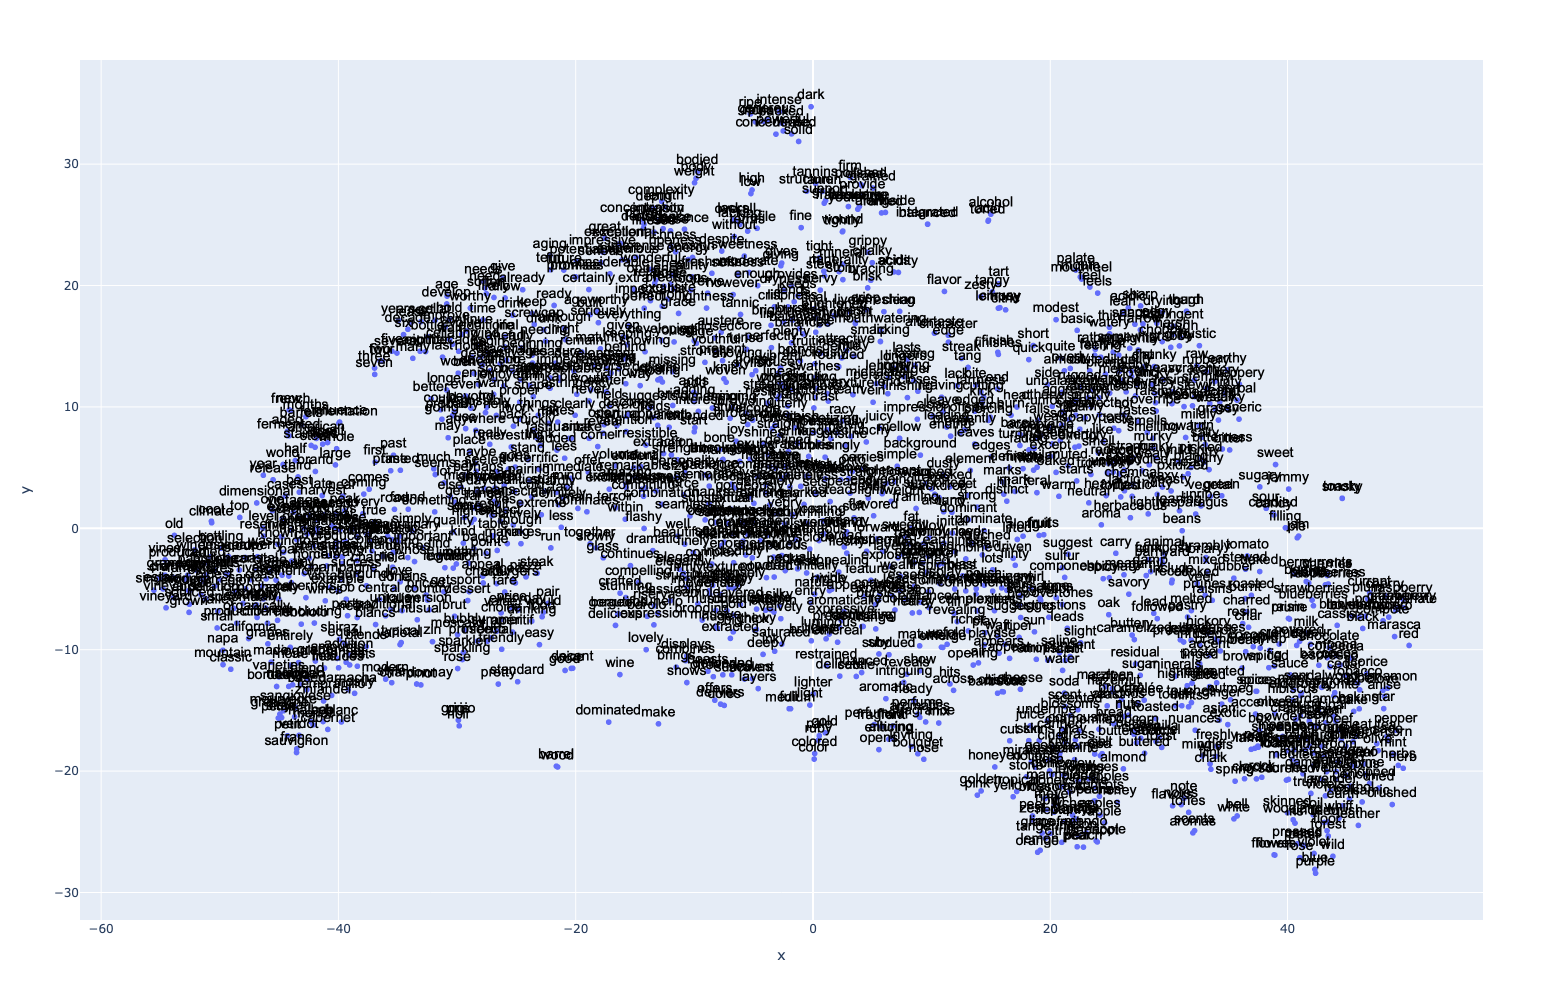

In [90]:
px.scatter(X.reset_index(), 'x', 'y', 
        text='term_str', 
        # color='pos_max', 
        hover_name='term_str',          
        height=1000,
        width=1200)\
    .update_traces(
        mode='markers+text', 
        textfont=dict(color='black', size=14, family='Arial'),
        textposition='top center')

# Semantic Algebra

## Analogies

$A : B :: C : D? \rightarrow B - A + C = D$


In [53]:
# model.wv.most_similar?

In [41]:
def complete_analogy(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [42]:
get_most_similar('white')

,term,sim
0,bell,0.758676
1,cracked,0.656100
2,yellow,0.577481
3,purple,0.569271
4,pit,0.558195
5,tropical,0.529861
6,stone,0.525097
7,passion,0.524899
8,riper,0.523389
9,blue,0.514062


In [43]:
get_most_similar('red')

,term,sim
0,wild,0.707620
1,black,0.679241
2,marasca,0.618158
3,blue,0.602944
4,briary,0.597176
5,pomegranate,0.557237
6,purple,0.555305
7,mixed,0.554620
8,forward,0.553787
9,strawberry,0.551238


In [44]:
complete_analogy('red', 'heavy', 'white', 3)

,term,sim
0,oily,0.660425
1,flabby,0.630225
2,flat,0.630201


## Similarites

In [45]:
get_most_similar('red')

,term,sim
0,wild,0.707620
1,black,0.679241
2,marasca,0.618158
3,blue,0.602944
4,briary,0.597176
5,pomegranate,0.557237
6,purple,0.555305
7,mixed,0.554620
8,forward,0.553787
9,strawberry,0.551238


In [46]:
get_most_similar('white')

,term,sim
0,bell,0.758676
1,cracked,0.656100
2,yellow,0.577481
3,purple,0.569271
4,pit,0.558195
5,tropical,0.529861
6,stone,0.525097
7,passion,0.524899
8,riper,0.523389
9,blue,0.514062


In [47]:
get_most_similar(positive=['white'], negative=['red'])

,term,sim
0,residual,0.420526
1,salt,0.410474
2,bell,0.397348
3,yeast,0.396957
4,sea,0.377081
5,pit,0.353352
6,butter,0.353285
7,popcorn,0.337690
8,honeysuckle,0.335335
9,appear,0.333488


In [48]:
get_most_similar(positive=['red'], negative=['white'])

,term,sim
0,skinned,0.405228
1,briary,0.401449
2,brambly,0.389414
3,blackberries,0.357476
4,extracted,0.349621
5,wild,0.348373
6,hard,0.347256
7,currants,0.341458
8,cassis,0.340684
9,plum,0.340123


# View with HAC

In [51]:
import sys
sys.path.append(local_lib)
from hac2 import HAC

<Figure size 640x480 with 0 Axes>

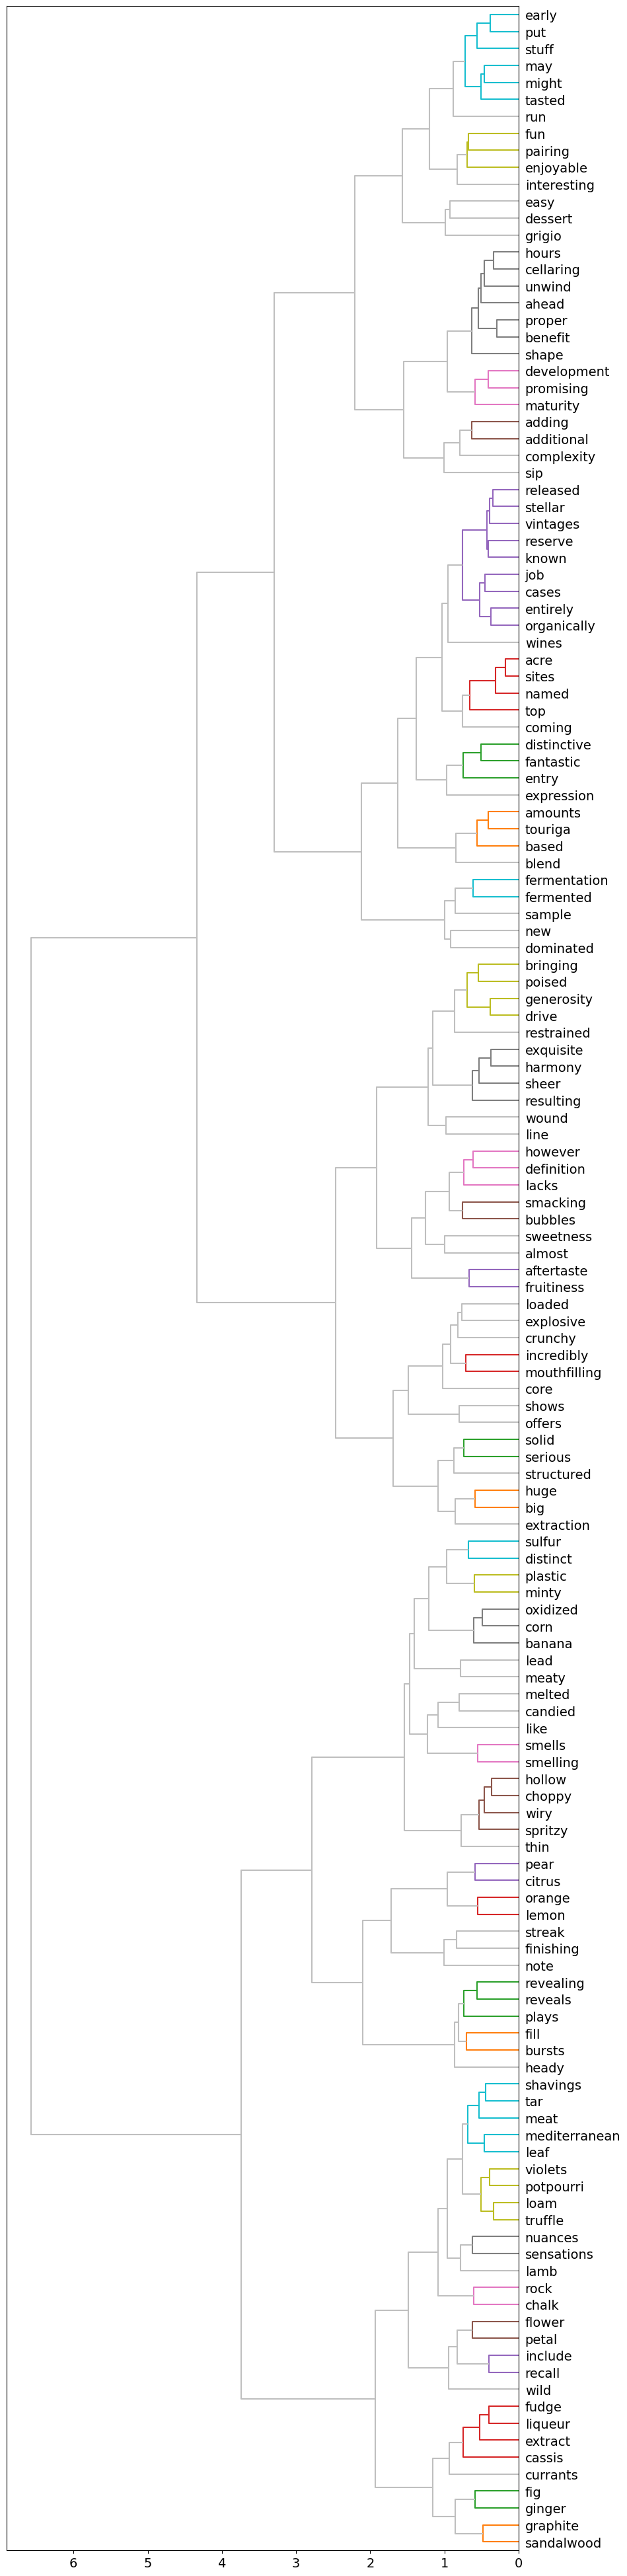

In [52]:
HAC(WV.sample(150)).plot()